In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
from whma.metrics import rel_err, rank_corr, mse_K_partial
from whma.cumulants import Cumulants, get_C_claw, get_K_th
from numba import autojit

In [2]:
d = 10
mus = 0.0005 * np.ones(d)
Alpha_truth = np.zeros((d,d))
Beta = np.zeros((d,d))
#Alpha_truth = np.ones((d,d)) / 15
for i in range(5):
    for j in range(5):
        if i <= j:
            Alpha_truth[i][j] = 1.
            Beta[i][j] = 50.
for i in range(5,10):
    for j in range(5,10):
        if i >= j:
            Alpha_truth[i][j] = 1.
            Beta[i][j] = 1.
Alpha_truth /= 6
#Alpha_truth = np.ones((d,d)) / 15

In [3]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.585556181944


In [4]:
hMax = 40
hDelta = .001
from math import log
# the criteria for beta_min and beta_max are designed for the exponential case
beta_min = log(1000) / hMax
beta_max = log(10./9.) / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  105.36051565782634


In [6]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 10000
h.simulate(T_max)
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

# Use the class Cumulants

In [7]:
N = h.get_full_process()
cumul = Cumulants(N,hMax=16)

In [8]:
cumul.compute_A()

In [9]:
cumul.compute_F()

In [10]:
cumul.set_C()

In [11]:
from scipy.linalg import inv
R_truth = inv(np.eye(d)-Alpha_truth)
cumul.set_C_th(R_truth)

In [12]:
cumul.set_K()

In [13]:
cumul.set_K_th(R_truth)

# Second order

In [14]:
#C_from_claw = get_C_claw(estim)

## Comparison

I define $C_{theory} = R \Sigma R^\top$ with $R = (I_d - ||\Phi||)^{-1}$

In [15]:
#print(rel_err(cumul.C_th,C_from_claw))
print(rel_err(cumul.C_th,cumul.C))

0.591466323905


# Third order

In [16]:
hMax_ = hMax

In [17]:
cumul.compute_F(H=hMax_)
cumul.set_K()

In [18]:
print(rel_err(cumul.K_th,cumul.K))

0.190962950205


## Estimation procedure for a smaller $hMax$

In [19]:
hMax_ = hMax*.4

In [20]:
cumul.compute_F(H=hMax_)
cumul.set_K()

In [23]:
print(rel_err(cumul.K_th,np.zeros_like(cumul.K_th)))
print(rel_err(cumul.K_th,cumul.K))

0.25
0.1942913463


# Minimize MSE on third order integrated cumulant

In [24]:
objective = lambda R: np.linalg.norm(cumul.K - get_K_th(cumul.L,cumul.C,R))**2

### L-BFGS doesn't work since the problem is non-convex

In [25]:
from scipy.optimize import fmin_l_bfgs_b
res = fmin_l_bfgs_b(objective,np.random.rand(d**2),approx_grad=1)
R_final = res[0].reshape(d,d)

In [26]:
print(rel_err(R_truth,np.zeros((d,d))))
print(rel_err(R_truth,R_final))

0.3
0.539256213245


### Let's try gradient descent like algorithms

In [27]:
@autojit
def gradient_f_ijk(R_,L_,C_,K_hat,i,j,k):
    d = len(L_)
    grad = np.zeros((d,d))
    grad[i] = R_[j]*C_[k] + R_[k]*C_[j] - 2*L_*R_[j]*R_[k]
    grad[j] = R_[i]*C_[k] + R_[k]*C_[i] - 2*L_*R_[i]*R_[k]
    grad[k] = R_[i]*C_[j] + R_[j]*C_[i] - 2*L_*R_[i]*R_[j]
    k_ijk = np.sum(R_[i]*R_[j]*C_[k] + R_[i]*C_[j]*R_[k] + C_[i]*R_[j]*R_[k] - 2*L_*R_[i]*R_[j]*R_[k])
    return (k_ijk - K_hat[i,j,k])*grad

@autojit
def gradient_f(R_,L_,C_,K_hat):
    d = len(L_)
    K_ = get_K_th(L_,C_,R_)
    grad_lines = np.einsum('im,jm->ijm',R_,C_)
    grad_lines += np.einsum('im,jm->ijm',C_,R_)
    grad_lines -= 2*np.einsum('m,im,jm->ijm',L_,R_,R_)
    diff_K = K_ - K_hat
    res = np.einsum('ijk,ijm->km',diff_K,grad_lines)
    res += np.einsum('ijk,ikm->jm',diff_K,grad_lines)
    res += np.einsum('ijk,jkm->im',diff_K,grad_lines)
    return res * 1./(d**3)

## Gradient checking

In [28]:
def simple_obj(R):
    K = get_K_th(cumul.L,cumul.C_th,R)
    return .5*np.linalg.norm(K)**2/(d**3)

def simple_grad(R_):
    K = get_K_th(cumul.L,cumul.C_th,R_)
    grad_lines = np.einsum('im,jm->ijm',R_,cumul.C_th)
    grad_lines += np.einsum('im,jm->ijm',cumul.C_th,R_)
    grad_lines -= 2*np.einsum('m,im,jm->ijm',cumul.L,R_,R_)
    res = np.einsum('ijk,ijm->km',K,grad_lines)
    res += np.einsum('ijk,ikm->jm',K,grad_lines)
    res += np.einsum('ijk,jkm->im',K,grad_lines)
    return res / (d**3)

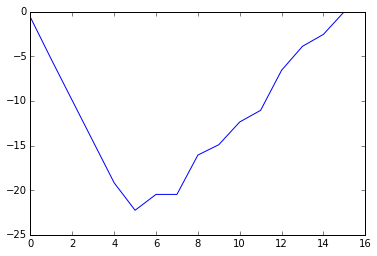

In [29]:
R0 = np.random.rand(d**2).reshape(d,d)
rand_mat = np.zeros((d,d))
a,b = np.random.randint(d), np.random.randint(d)
rand_mat[a,b] += 1.
i,j,k = np.random.randint(d), np.random.randint(d), np.random.randint(d)
erreur = []
res2 = np.einsum('ij,ij',simple_grad(R0),rand_mat)
for u in np.arange(0,-16,-1):
    eps = 10 ** u
    res1 = (simple_obj(R0+eps*rand_mat)-simple_obj(R0-eps*rand_mat))/(2*eps)
    erreur.append(abs(res1-res2)/abs(res2))
plt.plot(np.log(erreur))

# Nesterov Accelerated Gradient

### I've added regularization on $R$

In [30]:
def prox_zero(X, lbd=1.):
    return X

def prox_l1(X, lbd=1.):
    X_abs = np.abs(X)
    return np.sign(X) * (X_abs - lbd) * (X_abs > lbd)

def prox_nuclear(X, lbd=1.):
    U, s, V = np.linalg.svd(X)
    s_thres = prox_l1(s, lbd=lbd)
    return np.dot(U,np.dot(np.diag(s_thres),V))

In [36]:
eta = 1e2
lbd_l1 = 1e-7
lbd_nuc = 1e-6

@autojit
def loss_over_time(maxiter,R0,penalty='zero'):
    R_old = R0.copy()
    R = R0.copy()
    Y = np.empty((d,d))
    loss_arr = np.empty(maxiter)
    rel_err_arr = np.empty(maxiter)
    
    if penalty == 'zero':
        prox = prox_zero
        lbd = 1.
    elif penalty == 'l1':
        prox = prox_l1
        lbd = lbd_l1
    elif penalty == 'nuclear':
        prox = prox_nuclear
        lbd = lbd_nuc
        
    for n in range(maxiter):
        Y[:] = R + (n-2.)/(n+1.)*(R-R_old)
        grad = gradient_f(Y,cumul.L,cumul.C_th,cumul.K)
        #(i,j,k) = np.random.randint(d), np.random.randint(d), np.random.randint(d)
        #grad = gradient_f_ijk(Y,cumul.L,cumul.C_th,cumul.K,i,j,k)
        R_old[:] = R
        R[:] = prox(Y - eta*grad,lbd)
        loss_arr[n] = objective(R) + lbd_l1*np.sum(abs(R))
        rel_err_arr[n] = rel_err(R_truth,R)
        
    return rel_err_arr, loss_arr, R

In [37]:
R0_ = np.arange(d**2).reshape(d,d)/(d**2)
res = loss_over_time(5000,R0_,penalty='l1')
rel_err_array = res[0]
loss = res[1]
R_final = res[2]

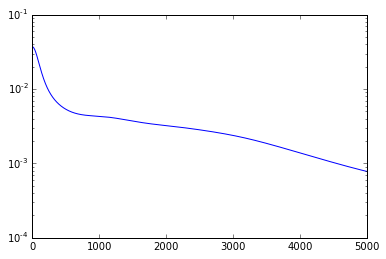

In [38]:
plt.plot(loss)
plt.yscale('log')

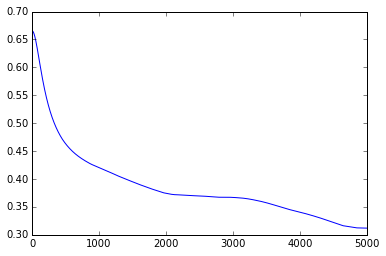

In [39]:
plt.plot(rel_err_array)
#plt.yscale('log')

In [40]:
print(rel_err(R_truth,np.zeros((d,d))))
print(rel_err(R_truth,R_final))

0.3
0.311949095973


In [42]:
from whma.optim import inspector, nag, gd

In [43]:
grad_fun = lambda X: gradient_f(X,cumul.L,cumul.C_th,cumul.K)
nag_inspector = inspector(objective,R_truth,verbose=True,n_iter=50)
R_nag = nag(R0_,grad_fun,n_iter=50,step=1e2,prox=prox_l1,lbd=lbd_l1,callback=nag_inspector)

   it    |   obj    | norm_grad
       0 | 3.70e-02 | 6.66e-01
      10 | 3.66e-02 | 6.65e-01
      20 | 3.58e-02 | 6.63e-01
      30 | 3.45e-02 | 6.60e-01
      40 | 3.29e-02 | 6.55e-01


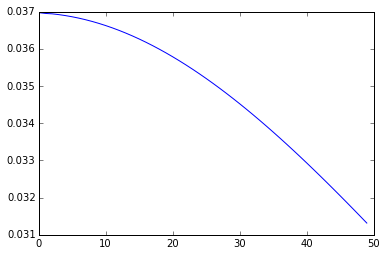

In [46]:
plt.plot(nag_inspector.obj)

In [ ]:
Alpha_pred = np.eye(d) - inv(R_final)

plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha_truth")
plt.colorbar()
plt.show()
plt.close()

In [ ]:
print(rel_err(Alpha_truth,Alpha_pred))

In [ ]:
Alpha_pred[Alpha_pred <= 0.] = 0.

plt.pcolor(Alpha_pred,cmap=plt.cm.Blues)
plt.title("Alpha_pred")
plt.colorbar()
plt.show()
plt.close()

In [ ]:
print(rel_err(Alpha_truth,Alpha_pred))

In [ ]:
plt.pcolor(np.log(Beta),cmap=plt.cm.Reds)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()